In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz

In [2]:
df = pd.read_csv('marketing_data.csv')
#Preprocess Income
df['Income']=df[' Income ']
df['Income']=df.Income.str.replace('$','')
df['Income']=df.Income.str.replace(',','')#.astype("Int64")
df['Income']=df.Income.astype("float")
df['Income'].fillna((df['Income'].median()), inplace=True)
df = df.drop([' Income '], axis=1)
df.drop(df.index[[527]],inplace=True)
df['LogIncome'] = np.log1p(df['Income'])

#Preprocess Education
df.loc[df['Education']=='2n Cycle','Education']='Master'
df.loc[df['Education']=='Graduation','Education']='Bachelor'

#Preprocess Children
df['NumChildren']  = df['Kidhome']+df['Teenhome']
df['HasChildren']=np.where(df.NumChildren> 0, 1, 0)

#Preprocess Marital Status
df['Solitary']=np.where(((df.Marital_Status== 'Married')|(df.Marital_Status== 'Together')), 0, 1)

#Preprocess Date and Make Age
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
df['age'] = 2014 - df['Year_Birth']

#Make total spending, num promotions, and num orders accepted columns
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] +\
        +df['MntSweetProducts'] + df['MntGoldProds']
df['AcceptedCmpTot']=df['AcceptedCmp1']+ df['AcceptedCmp2']+ df['AcceptedCmp3']+ df['AcceptedCmp4']+\
       + df['AcceptedCmp5']
df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases']+df['NumCatalogPurchases']+\
    df['NumStorePurchases']+df['NumWebVisitsMonth']

# Make a column for spending normalized by length customer -> Consider doing this for other amounts as well
latest_date=(df["Dt_Customer"] + pd.to_timedelta(df['Recency'],'d')).max()
df['Len_Customer']=latest_date - df["Dt_Customer"]
df['Len_Customer']=df['Len_Customer'] / pd.to_timedelta(1, unit='D') #Convert to float
df['MntSpentNorm']=df['MntTotal']/df['Len_Customer']

In [3]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm'],
      dtype='object')

In [4]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','Solitary',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntSpentNorm','MntTotal', 'AcceptedCmpTot','NumTotalPurchases','Year_Birth'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
X.head()

,MntGoldProds,NumChildren,NumCatalogPurchases,NumDealsPurchases,MntSweetProducts,MntFishProducts,Recency,Income,NumStorePurchases,NumWebPurchases,age,Len_Customer,MntMeatProducts,MntFruits,MntWines,NumWebVisitsMonth
0,218,0,4,1,189,111,0,84835.0,6,4,44,110.0,379,104,189,1
1,37,0,3,1,0,7,0,57091.0,7,7,53,111.0,64,5,464,5
2,30,1,2,1,2,15,0,67267.0,5,3,56,144.0,59,11,134,2
3,0,2,0,1,0,0,0,32474.0,2,1,47,146.0,1,0,10,7
4,34,1,1,2,0,11,0,21474.0,2,3,25,179.0,24,16,6,7


In [7]:
np.shape(X)

(2239, 16)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

# IF DO PCA, UNCOMMENT THE CELL BELOW

In [9]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 0.95)
# pca.fit(data_rescaled)
# reduced = pca.transform(data_rescaled)
# print(np.shape(reduced))
# num_components = np.shape(reduced)[1]
# print(num_components)
# columns = ['col'+str(i) for i in range(1,num_components)]
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(reduced)

# IF DO PCA, COMMENT OUT THE CELL BELOW

In [10]:
num_components=np.shape(X)[1]

Elbow Method:


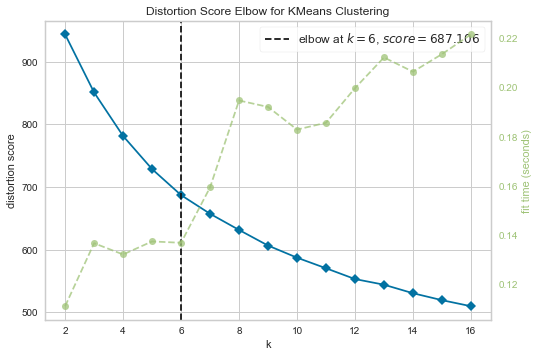

In [15]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method:')
Elbow_M = KElbowVisualizer(KMeans(), k=num_components, random_seed=123) #for the 20 numeric
Elbow_M.fit(data_rescaled) 
Elbow_M.show();

In [16]:
n_clusters=6

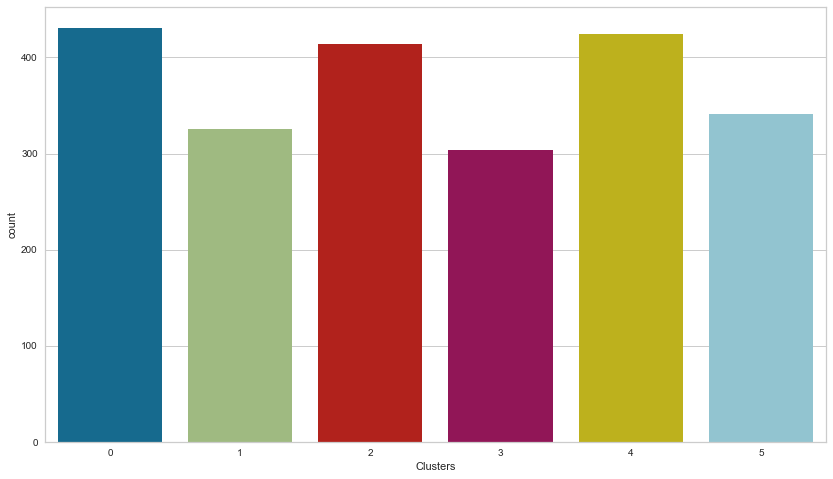

In [17]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Clusters'] = kmeans.fit_predict(data_rescaled)

plt.figure(figsize=(14, 8))
sns.countplot(x='Clusters', data=df)
plt.show()

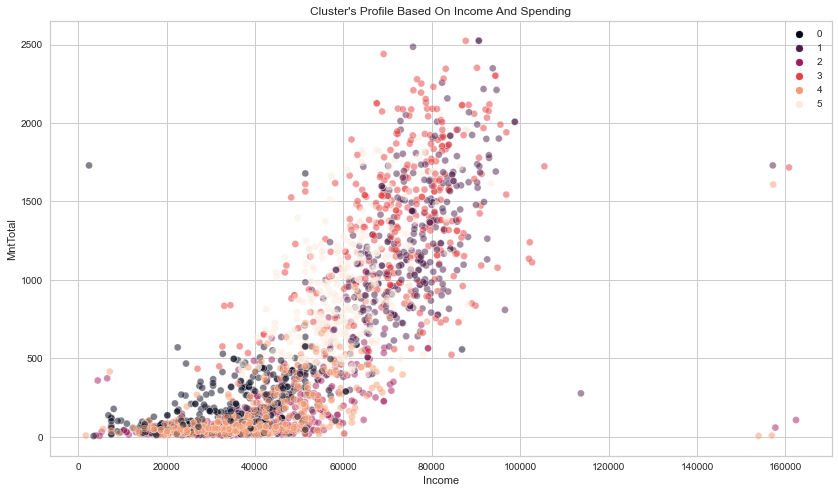

In [18]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

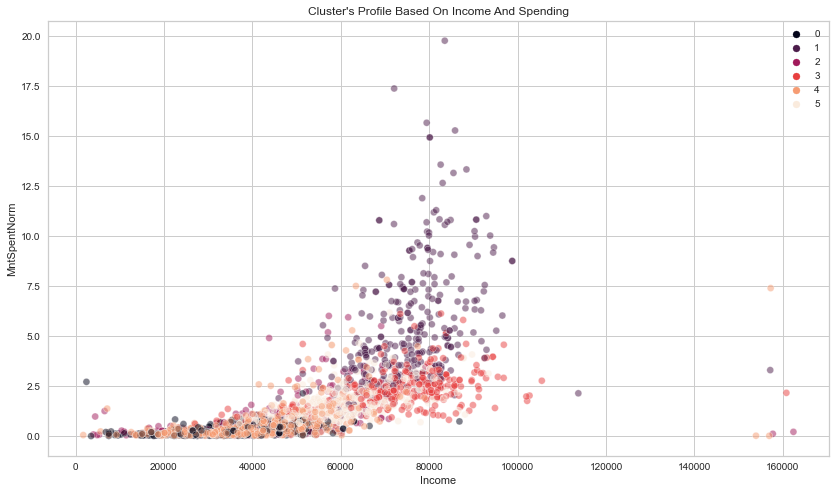

In [19]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [40]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters', 'MntWinesNorm', 'MntFruitsNorm',
       'MntMeatProductsNorm', 'MntFishProductsNorm', 'MntSweetProductsNorm',
       'MntGoldProdsNorm', 'NumDealsPurchasesNorm', 'NumWebPurchasesNorm',
       'NumStorePurchasesNorm', 'NumWebVisitsMonthNorm',
       'NumCatalogPurchasesNorm', 'AcceptedCmpTotNorm'],
      dtype='object')

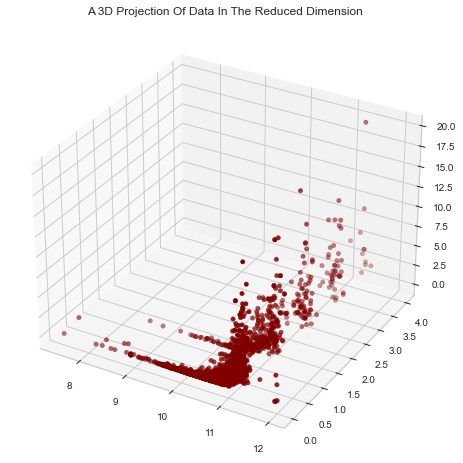

In [47]:
# x =df["LogIncome"]
# y =df["AcceptedCmpTot"]
# z =df["MntSpentNorm"]
# #To plot
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(x,y,z, c="maroon", marker="o" )
# ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
# plt.show()

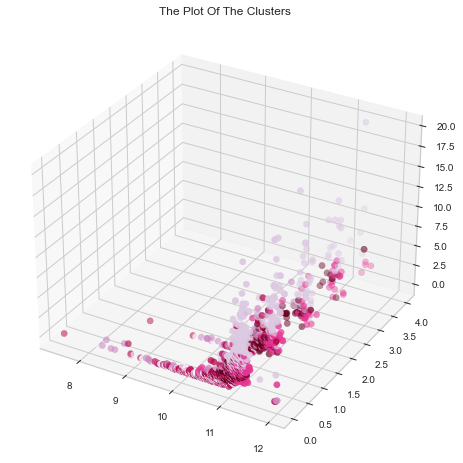

In [52]:
# x =df["LogIncome"]
# y =df["AcceptedCmpTot"]
# z =df["MntSpentNorm"]
# fig = plt.figure(figsize=(10,8))
# ax = plt.subplot(111, projection='3d', label="bla")
# ax.scatter(x, y, z, s=40, c=df["Clusters"], marker='o', cmap = 'PuRd' )
# ax.set_title("The Plot Of The Clusters")
# plt.show()

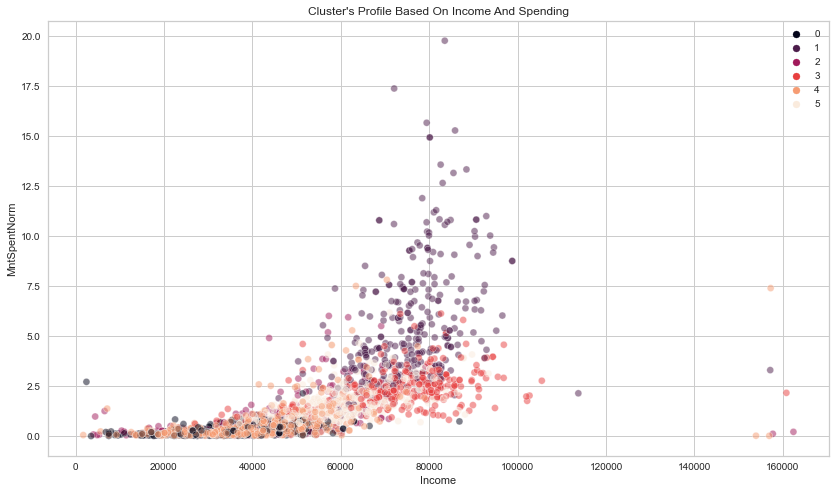

In [19]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [20]:
df["Clusters"].value_counts()

0    431
4    424
2    414
5    341
1    325
3    304
Name: Clusters, dtype: int64

<AxesSubplot:>

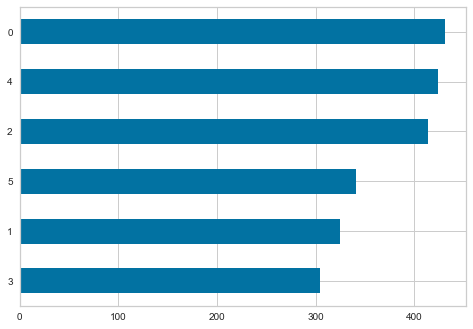

In [21]:
df.Clusters.value_counts().sort_values().plot(kind = 'barh')

In [22]:
groupsKmeans=df.groupby(['Clusters'])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

In [23]:
groupsKmeans.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                               Year_Birth  \
         count      sum min    max         mean          std      count   
Clusters                                                                  
0          431  2504772   9  11187  5811.535963  3275.912378        431   
1          325  1816325  75  11074  5588.692308  3231.472556        325   
2          414  2370662   1  11191  5726.236715  3286.622618        414   
3          304  1699475   0  11112  5590.378289  3158.667649        304   
4          424  2288894  13  11188  5398.334906  3219.189588        424   
5          341  1836878  17  11088  5386.739003  3281.772648        341   

                                                     Kidhome               \
             sum   min   max         mean        std   count  sum min max   
Clusters                                                                    
0         849851  1946  1996  1971.812065  11.164289     431  298   0   2   
1         639485  1899  1995  1967.646154  13.788113     325   15   0   2   
2         815538  1893  1992  1969.898551  11.568905     414  285   0   2   
3         598505  1941  1995  1968.766447  13.101837     304    8   0   1   
4         834867  1900  1996  1969.025943  11.534788     424  306   0   2   
5         669902  1943  1992  1964.521994   9.644731     341   82   0   2   

                             Teenhome                                   \
              mean       std    count  sum min max      mean       std   
Clusters                                                                 
0         0.691415  0.510263      431  195   0   2  0.452436  0.525567   
1         0.046154  0.224349      325   74   0   2  0.227692  0.427275   
2         0.688406  0.536341      414  232   0   2  0.560386  0.534501   
3         0.026316  0.160337      304   61   0   2  0.200658  0.409297   
4         0.721698  0.543955      424  256   0   2  0.603774  0.570003   
5         0.240469  0.441527      341  316   0   2  0.926686  0.417158   

         Recency                                      MntWines               \
           count    sum min max       mean        std    count     sum  min   
Clusters                                                                      
0            431  19699   0  99  45.705336  25.891616      431   32015    0   
1            325  14356   0  99  44.172308  28.267590      325  176723    1   
2            414   9312   0  53  22.492754  14.847855      414   36537    0   
3            304  16281   1  99  53.555921  29.045830      304  183449    7   
4            424  32877  48  99  77.540094  13.992342      424   36588    0   
5            341  17457   0  99  51.193548  26.809087      341  215495  115   

                                       MntFruits                             \
           max        mean         std     count    sum min  max       mean   
Clusters                                                                      
0          462   74.280742   90.501459       431   3266   0  103   7.577726   
1         1478  543.763077  305.285652       325  19923   0  197  61.301538   
2          738   88.253623  131.557796       414   2151   0   61   5.195652   
3         1493  603.450658  305.935072       304  22985   0  199  75.608553   
4          734   86.292453  122.880246       424   2455   0   70   5.790094   
5         1492  631.950147  312.696480       341   8123   0  138  23.821114   

                    MntMeatProducts                                            \
                std           count     sum min   max        mean         std   
Clusters                                                                        
0         11.403095             431   19224   1  1725   44.603248  117.500828   
1         49.689917             325  127046   3  1725  390.910769  226.567138   
2          8.636758             414   12439   0   257   30.045894   39.264550   
3         49.922925             304  140384  64  1622  461.789474

In [24]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,Solitary,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,5590.444841,1968.802144,0.443948,0.506476,49.121036,304.067441,26.307727,167.016525,37.538633,27.074587,44.036177,2.324252,4.085306,2.662796,5.791425,5.316213,0.072800,0.074587,0.072800,0.064314,0.013399,0.149174,0.009379,51963.554712,10.753637,0.950424,0.715051,0.355516,45.197856,606.041090,0.297901,20.179991,450.564984,1.653499,2.441268
std,3246.372471,11.985494,0.538390,0.544555,28.963662,336.614830,39.781468,225.743829,54.637617,41.286043,52.174700,1.932345,2.779240,2.923542,3.251149,2.427144,0.259867,0.262782,0.259867,0.245367,0.115001,0.356339,0.096412,21410.672116,0.500189,0.751970,0.451491,0.478776,11.985494,602.274089,0.678503,7.294595,202.166032,2.173316,1.727922
min,0.000000,1893.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2827.500000,1959.000000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35533.500000,10.478259,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.500000,0.201684,1.000000
50%,5455.000000,1970.000000,0.000000,0.000000,49.000000,174.000000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,0.000000,44.000000,396.000000,0.000000,19.000000,452.000000,0.865629,2.000000
75%,8423.500000,1977.000000,1.000000,1.000000,74.000000,504.500000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68277.500000,11.131350,1.000000,1.000000,1.000000,55.000000,1046.000000,0.000000,25.000000,626.000000,2.270569,4.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,121.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,5.000000


[75071.0, 393196.00000000006, 63619.0, 430421.0, 69157.0, 325462.0]
['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']


<AxesSubplot:>

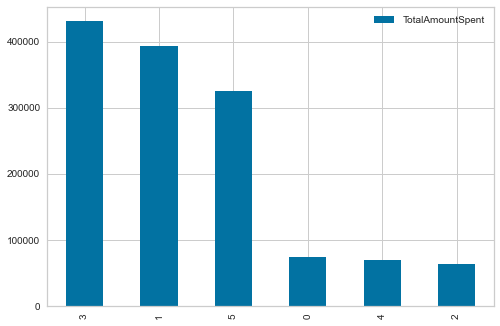

In [25]:
cluster_mnt_totals = [[]]*n_clusters

for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntTotal.mean()*len(cluster_i)

print(cluster_mnt_totals) 

columns = ['cluster'+str(i) for i in range(n_clusters)]
print(columns)

df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'TotalAmountSpent'},axis=1)

df_cluster_mnt_totals.sort_values('TotalAmountSpent', ascending=False).plot.bar()

# Description of Customer Characteristics
- Cluster 0: Lowest median income of all clusters (1 std to the left). The biggest cluster.
- Cluster 1: High median income (1 std to the right)
- Cluster 2: Lower than average median income (.5 std to the left)
- Cluster 3: High median income (1 std to the right)
- Cluster 4: Lower than average median income (.5 std to the left)
- Cluster 5: Highish median income (.5 std to the right)
- All clusters similar in age, with Cluster 0 slightly younger 

# Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.

In [26]:
#palette=sns.color_palette("rocket")
palette=sns.color_palette("Set2")

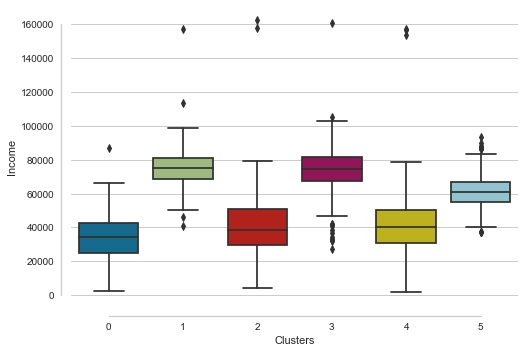

In [27]:
sns.boxplot(x="Clusters", y="Income",
            data=df)
sns.despine(offset=10, trim=True)

### Clusters 1 and 3 are the high income clusters

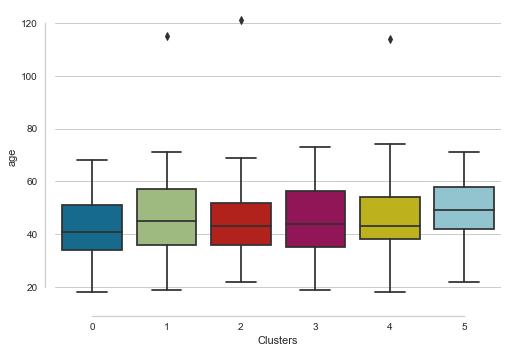

In [28]:
sns.boxplot(x="Clusters", y="age",
            data=df)
sns.despine(offset=10, trim=True)

### Age is similar across clusters, with median age in the 40s

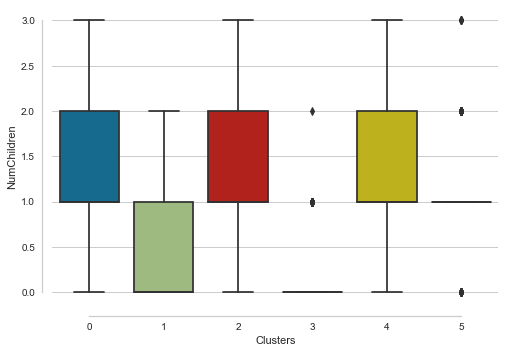

In [29]:
sns.boxplot(x="Clusters", y="NumChildren",
            data=df)
sns.despine(offset=10, trim=True)

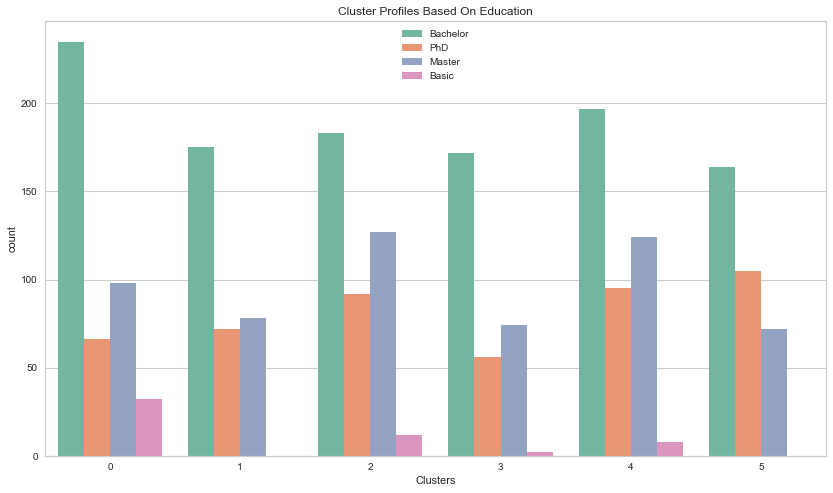

In [30]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["Education"], palette = palette)

plot.set_title("Cluster Profiles Based On Education")
plt.legend()
plt.show()

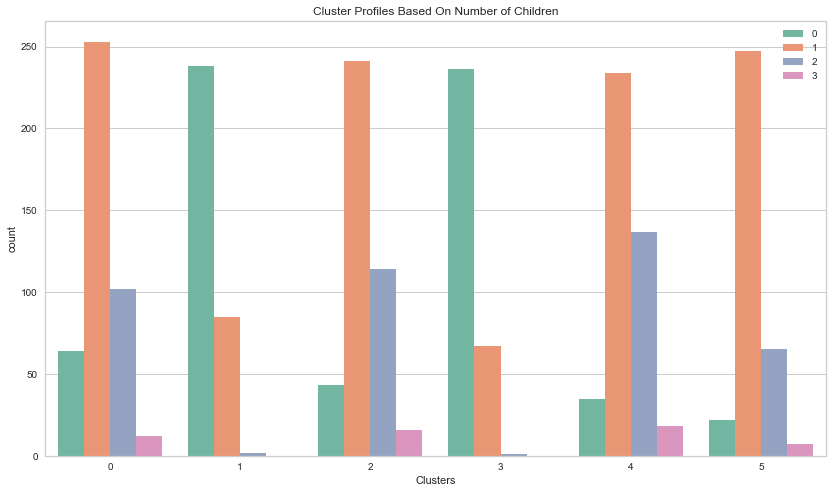

In [31]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["NumChildren"], palette = palette)

plot.set_title("Cluster Profiles Based On Number of Children")
plt.legend()
plt.show()

### Most customers in Clusters 1 and 3 don't have children, but Cluster 1 customers are likelier to have at least one child

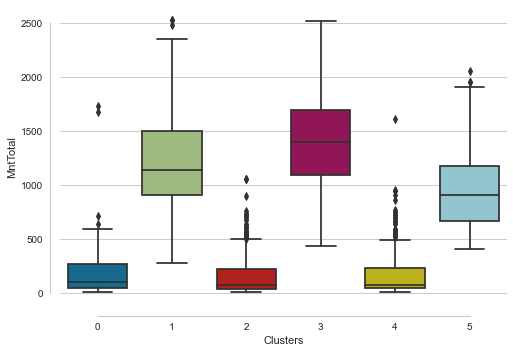

In [32]:
sns.boxplot(x="Clusters", y="MntTotal",
            data=df)
sns.despine(offset=10, trim=True)

### Cluster 3 customers have the highest median overall spending, followed by Cluster 1 and 5 customers

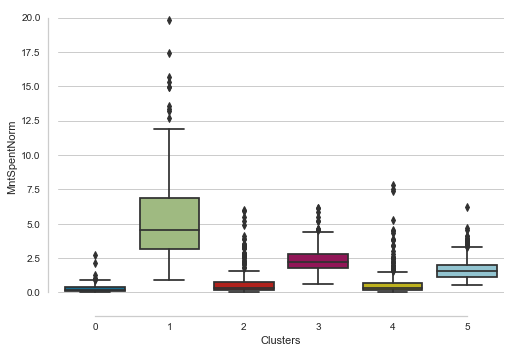

In [33]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            #hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

### However, when we normalize by length someone has been a customer, Cluster 1 customers spend much more!

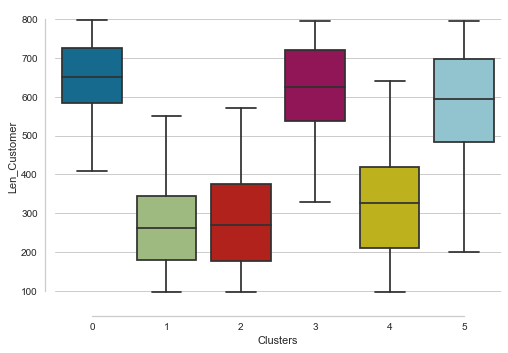

In [34]:
sns.boxplot(x="Clusters", y="Len_Customer",
            #hue="AcceptedCmpTot", palette=["m", "g","y","b","p"],
            data=df)
sns.despine(offset=10, trim=True)

### Compared to Cluster 1, Cluster 3 have been with the comapany much longer.  However, Cluster 1 has been with the company even longer and Cluster 5 has been with the company a long time as well.

### As seen below, if we normalize by length spent as customer, Cluster 1 spends the most in every category

In [35]:
df['MntWinesNorm']=df['MntWines']/df['Len_Customer']

df['MntFruitsNorm']=df['MntFruits']/df['Len_Customer']

df['MntMeatProductsNorm']=df['MntMeatProducts']/df['Len_Customer']

df['MntFishProductsNorm']=df['MntFishProducts']/df['Len_Customer']

df['MntSweetProductsNorm']=df['MntSweetProducts']/df['Len_Customer']

df['MntGoldProdsNorm']=df['MntGoldProds']/df['Len_Customer']

df['NumDealsPurchasesNorm']=df['NumDealsPurchases']/df['Len_Customer']

df['NumWebPurchasesNorm']=df['NumWebPurchases']/df['Len_Customer']

df['NumStorePurchasesNorm']=df['NumStorePurchases']/df['Len_Customer']

df['NumWebVisitsMonthNorm']=df['NumWebVisitsMonth']/df['Len_Customer']

df['NumCatalogPurchasesNorm']=df['NumCatalogPurchases']/df['Len_Customer']

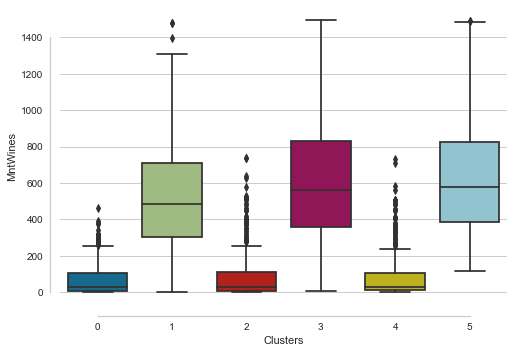

In [36]:
sns.boxplot(x="Clusters", y="MntWines",
            data=df)
sns.despine(offset=10, trim=True)

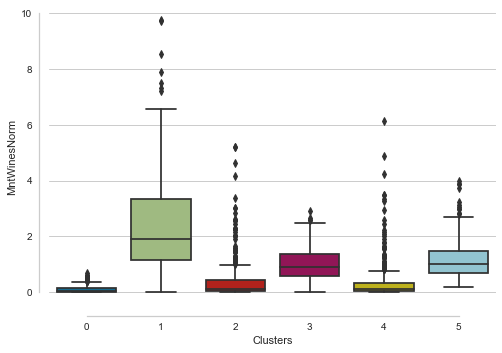

In [66]:
sns.boxplot(x="Clusters", y="MntWinesNorm",
            data=df)
sns.despine(offset=10, trim=True)

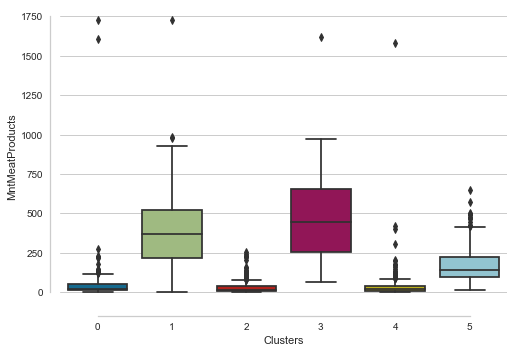

In [28]:
sns.boxplot(x="Clusters", y="MntMeatProducts",
            data=df)
sns.despine(offset=10, trim=True)

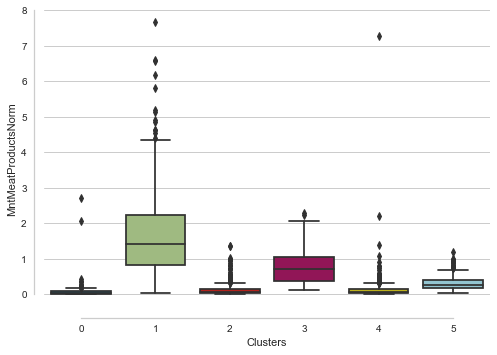

In [67]:
sns.boxplot(x="Clusters", y="MntMeatProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

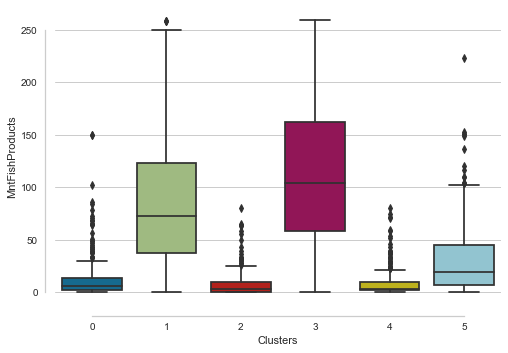

In [29]:
sns.boxplot(x="Clusters", y="MntFishProducts",
            data=df)
sns.despine(offset=10, trim=True)

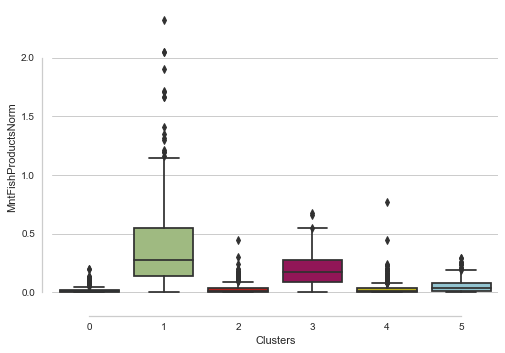

In [68]:
sns.boxplot(x="Clusters", y="MntFishProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

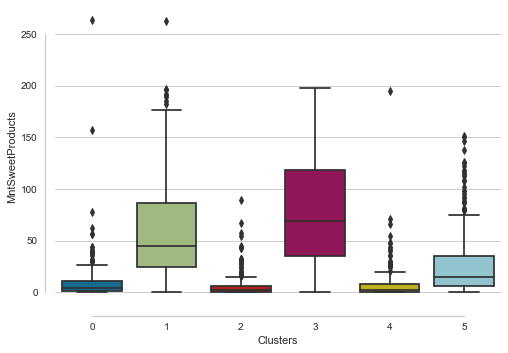

In [30]:
sns.boxplot(x="Clusters", y="MntSweetProducts",
            data=df)
sns.despine(offset=10, trim=True)

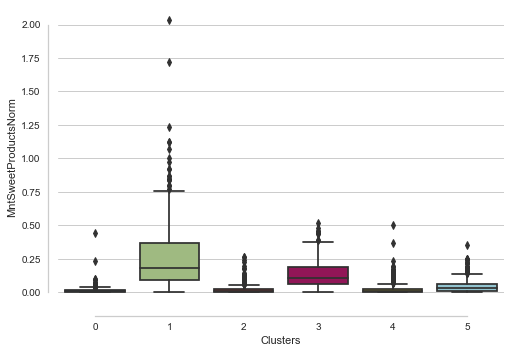

In [69]:
sns.boxplot(x="Clusters", y="MntSweetProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

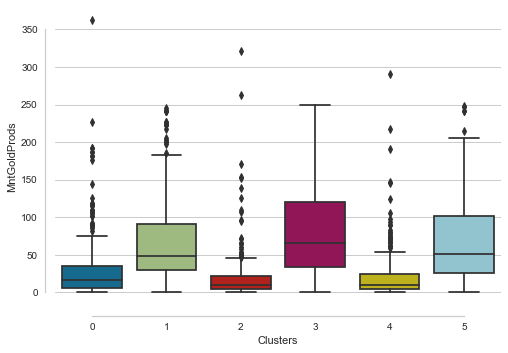

In [31]:
sns.boxplot(x="Clusters", y="MntGoldProds",
            data=df)
sns.despine(offset=10, trim=True)

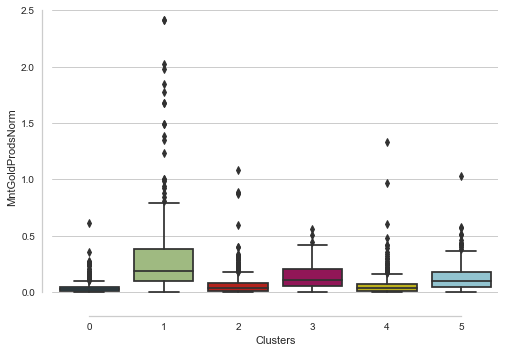

In [70]:
sns.boxplot(x="Clusters", y="MntGoldProdsNorm",
            data=df)
sns.despine(offset=10, trim=True)

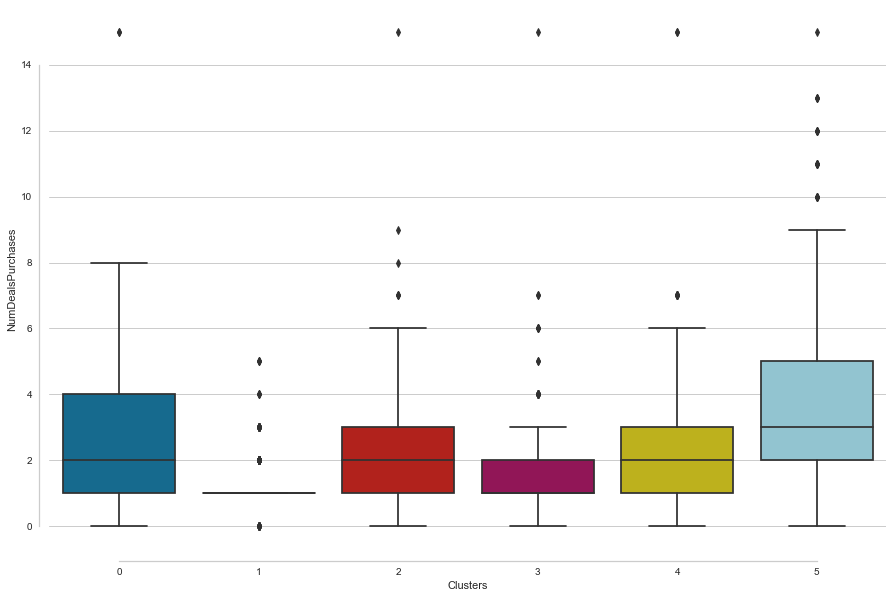

In [88]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="NumDealsPurchases",
            data=df)
sns.despine(offset=10, trim=True)

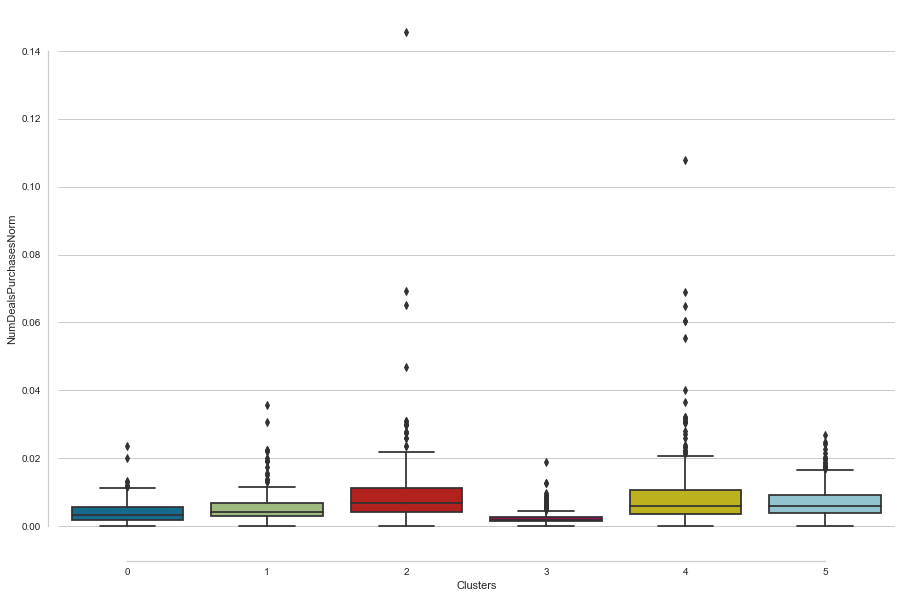

In [89]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="NumDealsPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

### Clusters 1 and 3 rarely go for deal purchases compared to Cluster 5, for example.  Cluster 5 customers are much more likely to have at least one child than clusters 1 and 3.  

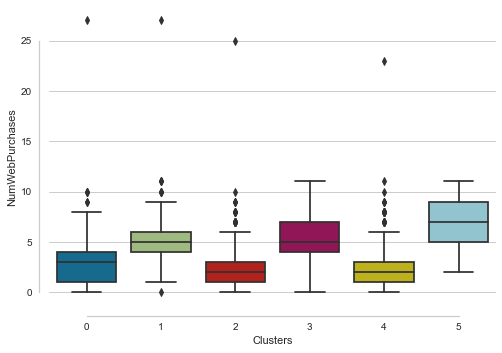

In [33]:
sns.boxplot(x="Clusters", y="NumWebPurchases",
            data=df)
sns.despine(offset=10, trim=True)

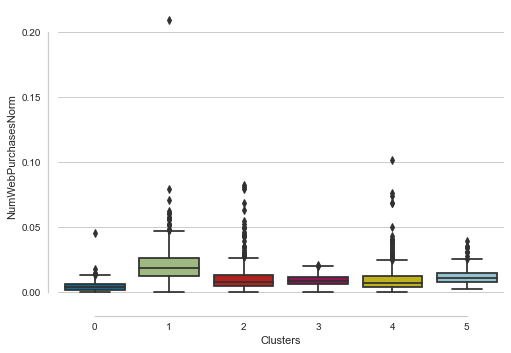

In [77]:
sns.boxplot(x="Clusters", y="NumWebPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

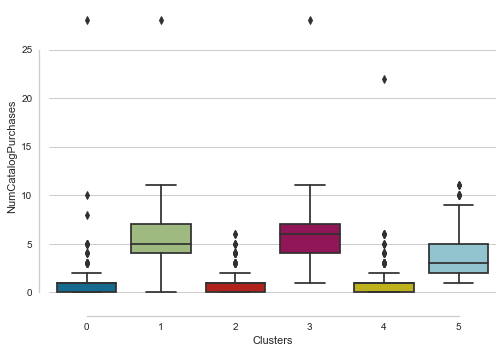

In [34]:
sns.boxplot(x="Clusters", y="NumCatalogPurchases",
            data=df)
sns.despine(offset=10, trim=True)

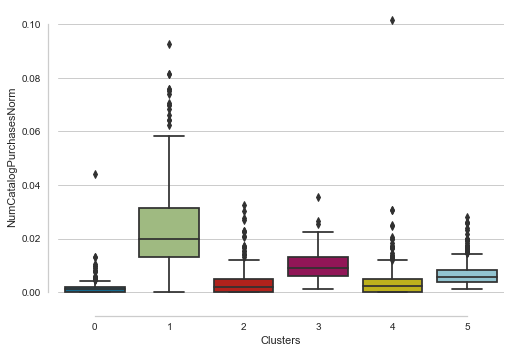

In [102]:
sns.boxplot(x="Clusters", y="NumCatalogPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

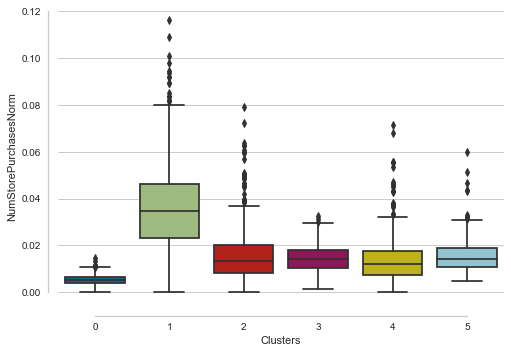

In [78]:
sns.boxplot(x="Clusters", y="NumStorePurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

# When normalized, Cluster 1 makes the most web, catalog and in-store puchases.  
# Cluster 3 relatively prone to catalog purchases
# Cluster 5 relatively prone to web purchases

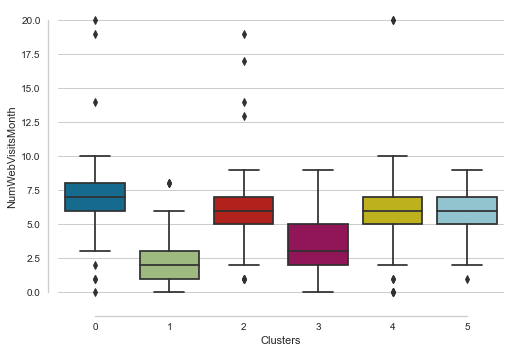

In [36]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonth",
            data=df)
sns.despine(offset=10, trim=True)

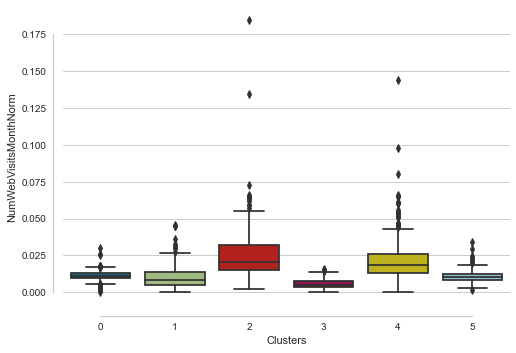

In [79]:
sns.boxplot(x="Clusters", y="NumWebVisitsMonthNorm",
            data=df)
sns.despine(offset=10, trim=True)

# Cluster 2 visit the web the most.  Cluster 4 is also active on the web.  Target a campaign for them there by giving them targeted deals!

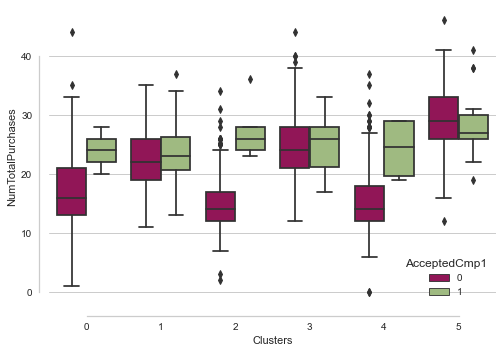

In [37]:
sns.boxplot(x="Clusters", y="NumTotalPurchases",
            hue="AcceptedCmp1", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

### Although 1 spend less than 3 total, their spending normalized by length as customers is much higher!
### Focus on attracting this recent revenue-bringing group

<AxesSubplot:xlabel='Clusters', ylabel='MntSpentNorm'>

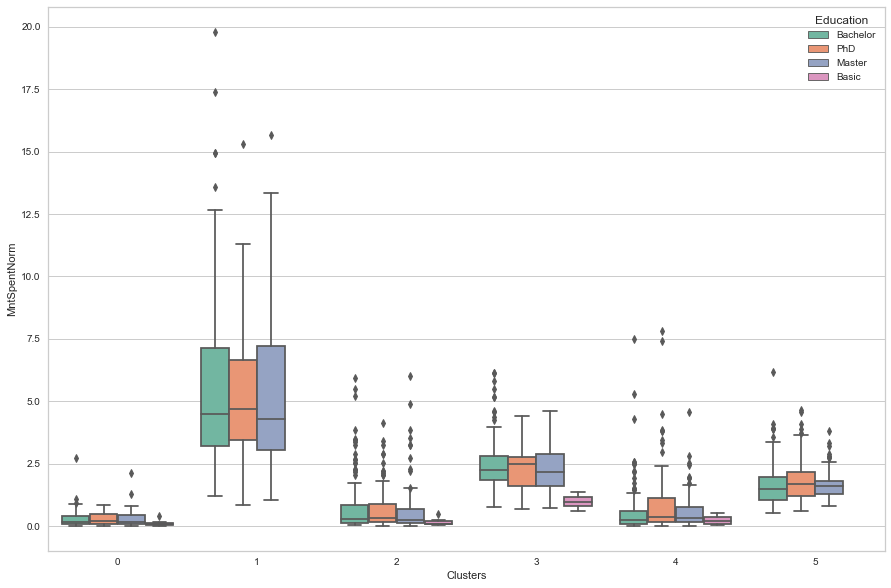

In [56]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="Education", palette=palette,
            data=df)
#sns.despine(offset=10, trim=True)

### Overall, higher-educated customers spend more

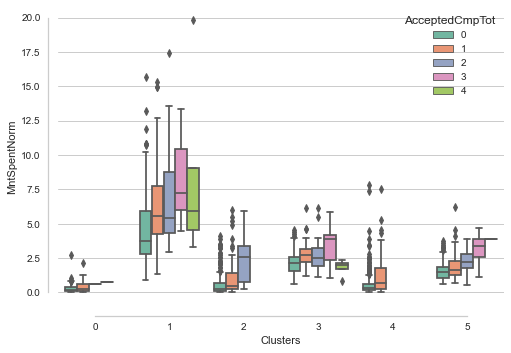

In [103]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

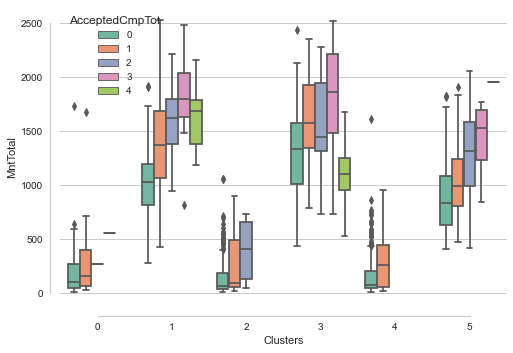

In [109]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

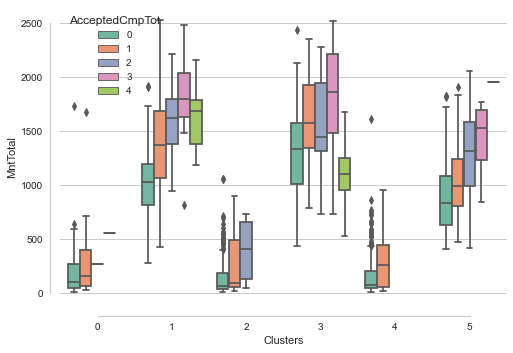

In [57]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

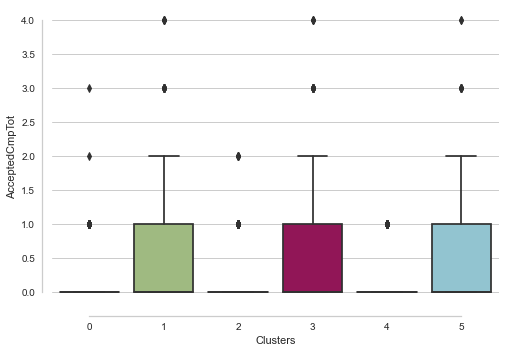

In [104]:
sns.boxplot(x="Clusters", y="AcceptedCmpTot",
            #hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

### What about the amounts spent on other goods when normalized?

In [42]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'Solitary', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters'],
      dtype='object')

In [37]:
# df['AcceptedCmpTotNorm']=df['AcceptedCmpTot']/df['Len_Customer'] Don't do that!


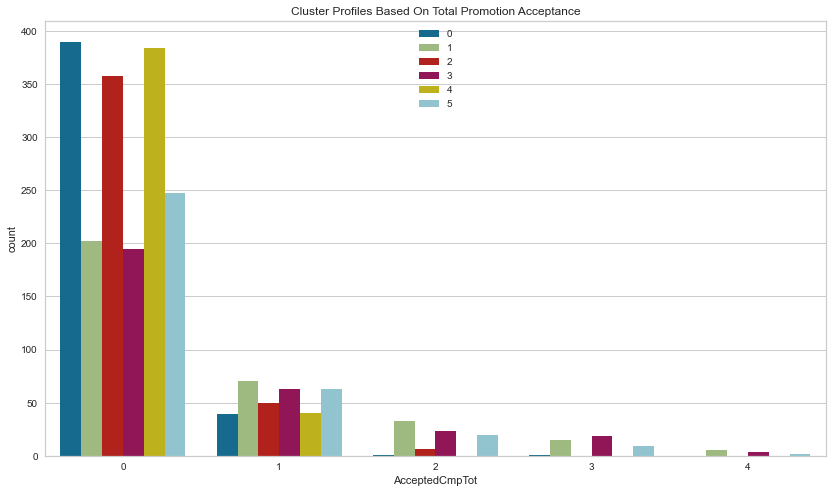

In [58]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmpTot"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Total Promotion Acceptance")
plt.legend()
plt.show()

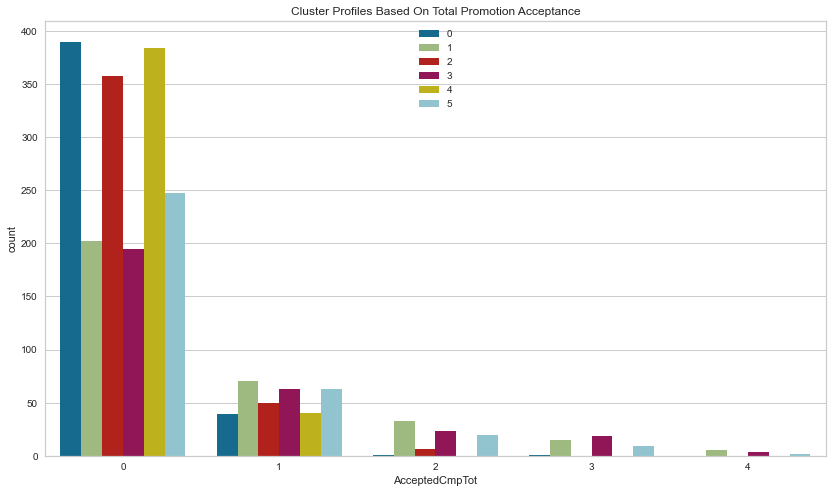

In [63]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmpTot"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Total Promotion Acceptance")
plt.legend()
plt.show()

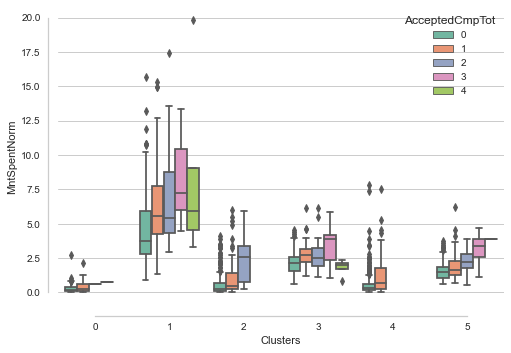

In [103]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

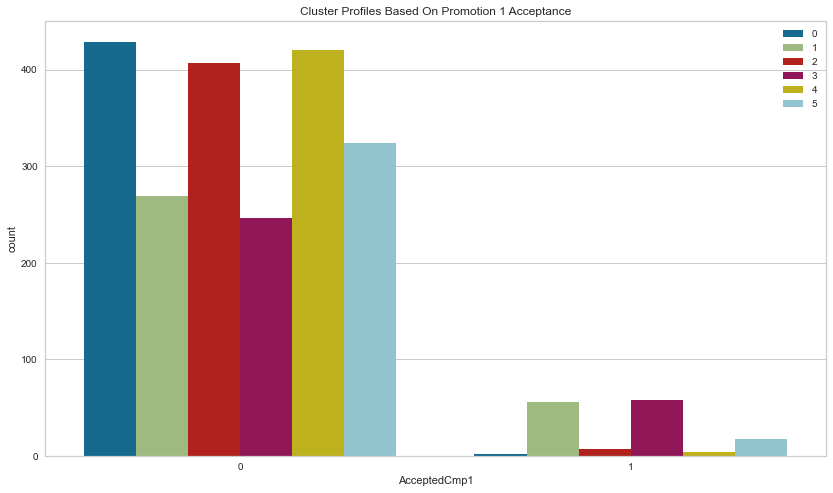

In [64]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp1"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 1 Acceptance")
plt.legend()
plt.show()

### Cluster 3 responded to campaign 1

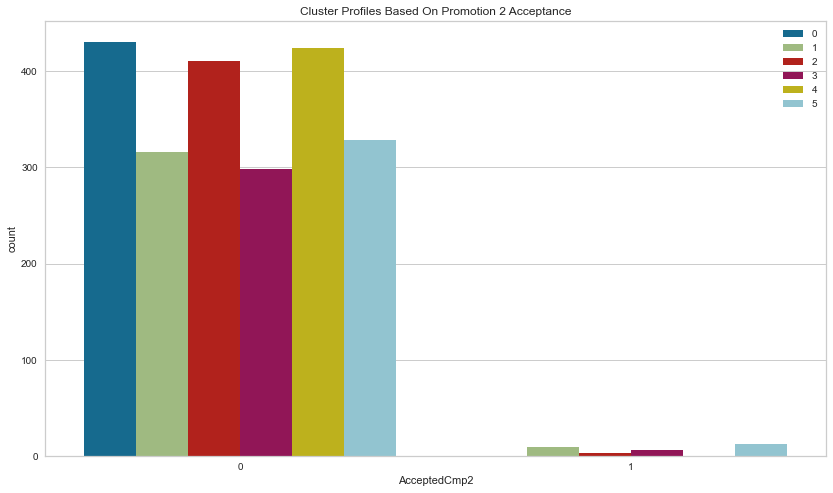

In [65]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp2"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 2 Acceptance")
plt.legend()
plt.show()

### Campaign 2 was unsuccessful base on response rate

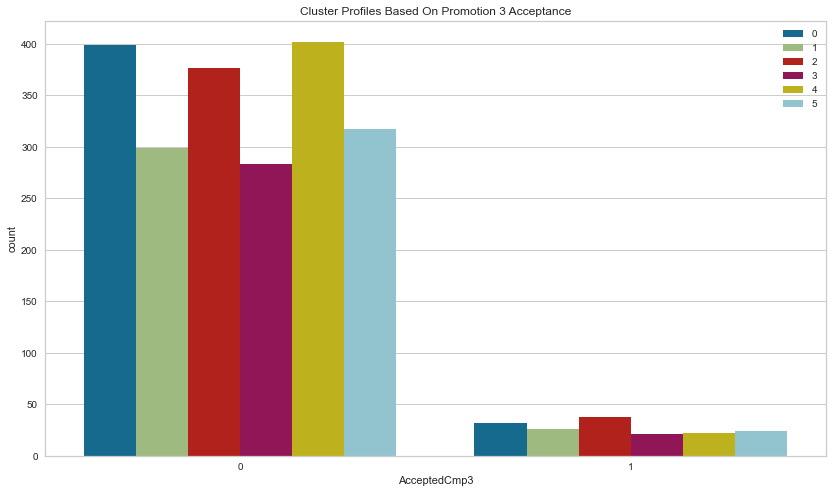

In [66]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp3"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 3 Acceptance")
plt.legend()
plt.show()

### Cluster 2 was particularly prone to accept campaign 3

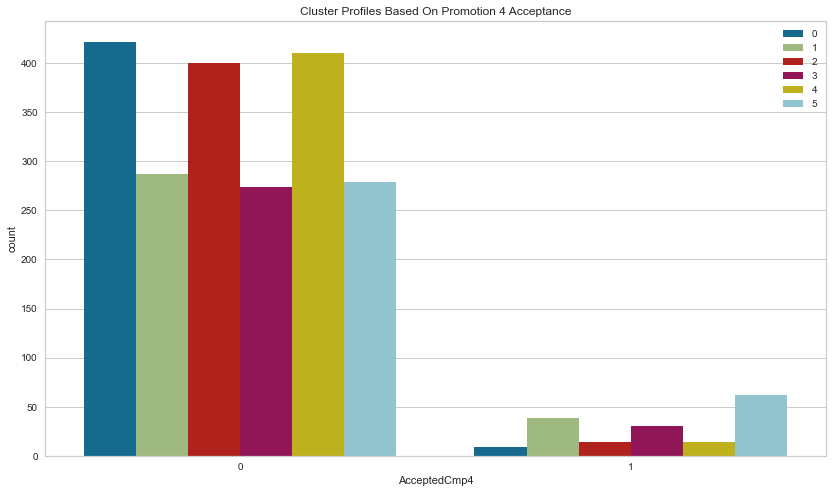

In [67]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp4"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 4 Acceptance")
plt.legend()
plt.show()

### Cluster 2 was particularly prone to accept campaign 4

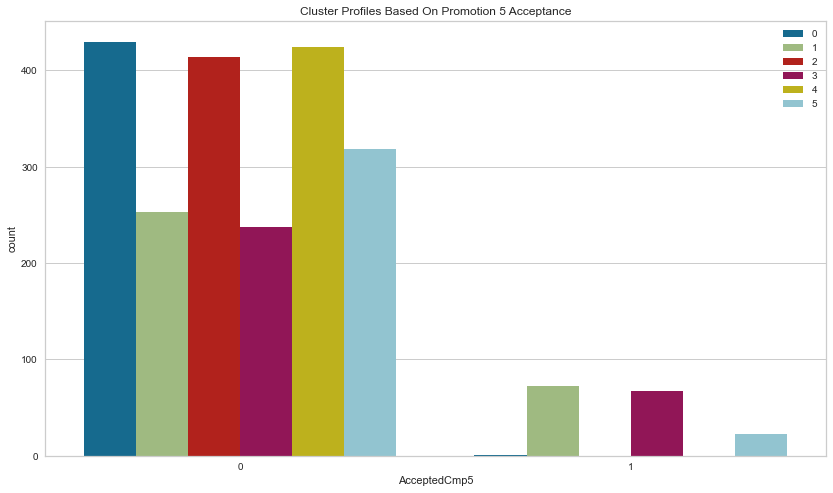

In [69]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp5"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Promotion 5 Acceptance")
plt.legend()
plt.show()

### Clusters 1 and 3 was particularly prone to accept campaign 5

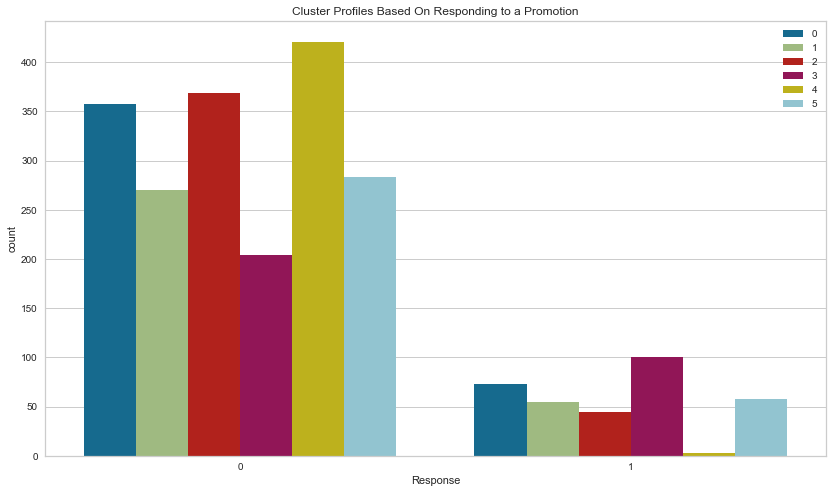

In [71]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Response"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Responding to a Promotion")
plt.legend()
plt.show()

### Not sure if 'Response' is particularly meaningful

### Cluster 4 is the most responsive to promotions.  Who are these customers?
- Upper middle class
- College educated or above, with a heavy represenation of people with PhDs
- Mostly married or living together
- Are less likely to have children than average, and have fewer children
- Story: Highly educated professors and professionals -> The "Strivers"
- We don't know much about these promotions, but perhaps they are for wines, meats, and more expensive items

### Cluster 1 are the repeated deal hunters.  Who are they?
- Higher than average income (.5 standard dev)
- Highly educated (lots of PhDs)
- Overwhelmingly have children
- The 'Familied Philosophers'

#### Recommend A/B testing on clusters